In [54]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from scipy.special import iv, kv , gammainc, gamma
from scipy.integrate import quad
import emcee
import multiprocessing, time
import corner
from numba import njit

k=7.6695
G= 4.302e-6

data= pd.read_csv("mw_r_v_sd.2", delim_whitespace=True, header=None, names=['x', 'y', 'error'])
xl=data['x']
yl=data['y']
el=data['error']
xl= np.array(xl)
yl = np.array(yl)
el = np.array(el)

/tmp/ipykernel_8220/51991405.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data= pd.read_csv("mw_r_v_sd.2", delim_whitespace=True, header=None, names=['x', 'y', 'error'])


# Velocities
## BULGE

In [55]:
@njit
def sigbr_x(x, sig_b, a_b):
    return sig_b * np.exp(-k * ((x / a_b)**0.25 - 1))

@njit
def dsigbr_x_dx(x, sig_b, a_b):
    prefactor = -(k / 4) * (1 / a_b)**0.25 * x**(-0.75)
    return prefactor * sigbr_x(x, sig_b, a_b)

@njit
def rho_bulge_numba(r, a_b, sig_b):
    result = 0.0
    du = (20.0 - 0.01) / 200
    for i in range(201):
        u = 0.01 + i * du
        x = r * np.cosh(u)
        integrand = dsigbr_x_dx(x, sig_b, a_b)
        weight = 1.0
        if i == 0 or i == 200:
            weight = 0.5
        result += weight * integrand
    integral = result * du
    return -integral / np.pi

@njit
def vb_numba(r, a_b, sig_b):
    if r <= 0:
        return 0.0
    result = 0.0
    dr = (r - 0.01) / 200
    for i in range(201):
        ri = 0.01 + i * dr
        integrand = rho_bulge_numba(ri, a_b, sig_b) * ri**2
        weight = 1.0
        if i == 0 or i == 200:
            weight = 0.5
        result += weight * integrand
    integral = result * dr
    vb2 = (4 * np.pi * G / r) * integral
    if vb2 > 0:
        return np.sqrt(vb2)
    return 0.0
def vb_nfw(r):
    return vb_numba(r, 1.764, 0.595e9)
def vb_hern(r):
    return vb_numba(r, 1.775, 0.592e9)
def vb_ein(r):
    return vb_numba(r, 1.775, 0.593e9,)

In [7]:
# def sigbr_x(x, sig_b, a_b):
#     return sig_b * np.exp(-k * ((x / a_b)**0.25 - 1))
# def dsigbr_x_dx(x, sig_b, a_b):
#     prefactor = -(k / 4) * (1 / a_b)**0.25 * x**(-0.75)
#     return prefactor * sigbr_x(x, sig_b, a_b)
# def rhob_r(r, sig_b, a_b):
#     def integrand(u):
#         x = r * np.cosh(u)
#         return dsigbr_x_dx(x, sig_b, a_b)
#     integral, _ = quad(integrand, 1e-2, 20)
#     return -integral / np.pi
# def v_bulge(r, sig_b, a_b):
#     def integrand_vb2_r(r_):
#         return rhob_r(r_, sig_b, a_b) * r_**2
#     integral, _ = quad(integrand_vb2_r, 1e-2, r)
#     vb2 = (4 * np.pi * G / r) * integral
#     if not np.isfinite(vb2) or vb2 <= 0:
#         return np.nan
    # return np.sqrt(vb2)



## DISK

In [8]:
'''
def vd_nfw(r):
    if r <= 0:
        return 0.0
    v2= np.pi*G* 0.566e9* (r**2/8.817) *(iv(0,r/(2*8.817))*kv(0,r/(2*8.817)) - iv(1,r/(2*8.817))*kv(1,r/(2*8.817)))
    if v2>0:
        return np.sqrt(v2)
    return 0.0
def vd_hern(r ):
    if r <= 0:
        return 0.0
    v2= np.pi*G* 0.552e9* (r**2/9.237) *(iv(0,r/(2*9.237))*kv(0,r/(2*9.237)) - iv(1,r/(2*9.237))*kv(1,r/(2*9.237)))
    if v2>0:
        return np.sqrt(v2)
    return 0.0
def vd_ein(r ):
    if r <= 0:
        return 0.0
    v2= np.pi*G* 0.578e9* (r**2/9.130) *(iv(0,r/(2*9.130))*kv(0,r/(2*9.130)) - iv(1,r/(2*9.130))*kv(1,r/(2*9.130)))
    if v2>0:
        return np.sqrt(v2)
    return 0.0
    '''


'\ndef vd_nfw(r):\n    if r <= 0:\n        return 0.0\n    v2= np.pi*G* 0.566e9* (r**2/8.817) *(iv(0,r/(2*8.817))*kv(0,r/(2*8.817)) - iv(1,r/(2*8.817))*kv(1,r/(2*8.817)))\n    if v2>0:\n        return np.sqrt(v2)\n    return 0.0\ndef vd_hern(r ):\n    if r <= 0:\n        return 0.0\n    v2= np.pi*G* 0.552e9* (r**2/9.237) *(iv(0,r/(2*9.237))*kv(0,r/(2*9.237)) - iv(1,r/(2*9.237))*kv(1,r/(2*9.237)))\n    if v2>0:\n        return np.sqrt(v2)\n    return 0.0\ndef vd_ein(r ):\n    if r <= 0:\n        return 0.0\n    v2= np.pi*G* 0.578e9* (r**2/9.130) *(iv(0,r/(2*9.130))*kv(0,r/(2*9.130)) - iv(1,r/(2*9.130))*kv(1,r/(2*9.130)))\n    if v2>0:\n        return np.sqrt(v2)\n    return 0.0\n    '

In [102]:
def vd_generic(r, a_d, sig_d):
    """
    Compute disk velocity array for given constants sigma_d and a_d.
    Accepts scalar or array r.
    """
    r = np.atleast_1d(r)
    # Avoid r <= 0
    valid = r > 0
    v2 = np.zeros_like(r)
    # Compute only for valid r
    x = r[valid] / (2 * a_d)
    term = iv(0, x) * kv(0, x) - iv(1, x) * kv(1, x)
    v2_val = np.pi * G * sig_d * (r[valid]**2 / a_d) * term
    # Non-negative check
    v2[valid] = np.where(v2_val > 0, v2_val, 0.0)
    # Return velocity
    v = np.sqrt(v2)
    # If scalar input, return scalar
    if v.ndim == 0:
        return float(v)
    elif v.size == 1:
        return v.item()
    else:
        return v


def vd_nfw_vec(r):
    return vd_generic(r, sig_d=0.566e9, a_d=8.817)

def vd_hern_vec(r):
    return vd_generic(r, sig_d=0.552e9, a_d=9.237)

def vd_ein_vec(r):
    return vd_generic(r, sig_d=0.578e9, a_d=9.130)

## HALO

In [57]:
'''
def vh_nfw(r, rho, h):
    if r <= 0:
        return 0.0
    v2= (G/r)*(4*np.pi*rho*h**3)* (np.log(1+(r/h))- ((r/h)/(1+ (r/h))))
    if v2>0:
        return np.sqrt(v2)
    return 0.0

def vh_hern(r, rho, h):
    if r <= 0:
        return 0.0
    v2= G*2*np.pi*rho*h*r/(1+ (r/h))**2
    if v2>= 0:
        return np.sqrt(v2)
    return 0.0

def vh_ein(r, rho_0, h, n):
    mass= 4* np.pi* rho_0* n* h**3* gamma(3*n) * gammainc(3*n, (r/h)**(1/n))
    v2= G*mass/r
    if v2>=0:
        return np.sqrt(v2)
    return 0.0
    '''

'\ndef vh_nfw(r, rho, h):\n    if r <= 0:\n        return 0.0\n    v2= (G/r)*(4*np.pi*rho*h**3)* (np.log(1+(r/h))- ((r/h)/(1+ (r/h))))\n    if v2>0:\n        return np.sqrt(v2)\n    return 0.0\n\ndef vh_hern(r, rho, h):\n    if r <= 0:\n        return 0.0\n    v2= G*2*np.pi*rho*h*r/(1+ (r/h))**2\n    if v2>= 0:\n        return np.sqrt(v2)\n    return 0.0\n\ndef vh_ein(r, rho_0, h, n):\n    mass= 4* np.pi* rho_0* n* h**3* gamma(3*n) * gammainc(3*n, (r/h)**(1/n))\n    v2= G*mass/r\n    if v2>=0:\n        return np.sqrt(v2)\n    return 0.0\n    '

In [58]:
"""
    Vectorized NFW halo velocity profile.
    r: scalar or array
    rho: density parameter
    h: scale radius
    """
def vh_nfw_vec(r, rho, h):
    r = np.atleast_1d(r)
    v2 = np.zeros_like(r)
    x = r[ r > 0] / h
    term = np.log1p(x) - x / (1 + x)
    v2_val = (G / r[ r > 0]) * (4 * np.pi * rho * h**3) * term
    v2[ r > 0] = np.where(v2_val > 0, v2_val, 0.0)
    v = np.sqrt(v2)
    return float(v) if v.shape == (1,) else v


    #Vectorized Hernquist halo velocity profile.
def vh_hern_vec(r, rho, h):
    r = np.atleast_1d(r)
    v2 = np.zeros_like(r)
    x = r[ r > 0] / h
    v2_val = G * 2 * np.pi * rho * h * r[ r > 0] / (1 + x)**2
    v2[ r > 0] = np.where(v2_val > 0, v2_val, 0.0)
    v = np.sqrt(v2)
    return float(v) if v.shape == (1,) else v

 
    #Vectorized Einasto halo velocity profile.
def vh_ein_vec(r, rho_0, h, n):
    r = np.atleast_1d(r)
    v2 = np.zeros_like(r)
    x = (r[ r > 0] / h)**(1/n)
    mass_val = 4 * np.pi * rho_0 * n * h**3 * gamma(3*n) * gammainc(3*n, x)
    v2_val = (G * mass_val) / r[ r > 0]
    v2[ r > 0] = np.where(v2_val > 0, v2_val, 0.0)
    v = np.sqrt(v2)
    return float(v) if v.shape == (1,) else v


# GRAPH

/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v


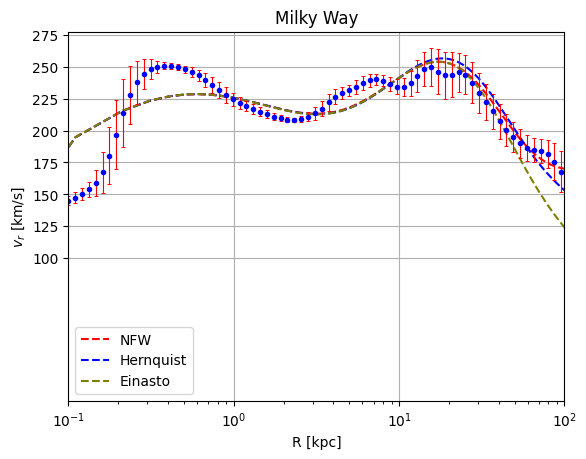

In [12]:
rs = np.linspace(0.01, 100, 1000)

# vtotal_nfw= np.sqrt ([ vb_nfw(r)**2 + vd_nfw(r)**2    + vh_nfw(r , 7120, 889)**2 for r in rs ]) 
# vtotal_hern= np.sqrt ([ vb_hern(r)**2 + vd_hern(r)**2 + vh_hern(r , 63090, 142.324)**2 for r in rs ]) 
# vtotal_ein= np.sqrt ([ vb_ein(r)**2 + vd_ein(r)**2    + vh_ein(r, 248660, 8.745, 0.041)**2 for r in rs ]) 
# vbulge_nfw = np.array([vb_nfw(x) for x in xl])
# vdisk  = np.array([vd_nfw(x) for x in xl])
# vhalo  = np.array([vh_nfw(x, rho, h) for x in xl])
# vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)

vb_nfwp = np.array([vb_nfw(x) for x in rs])
vd_nfw  = np.array([vd_nfw_vec(x) for x in rs])
vh_nfw  = np.array([vh_nfw_vec(x, rho=7120, h=889) for x in rs])
vth_nfw = np.sqrt(vb_nfwp**2 +vd_nfw**2 + vh_nfw**2)

vb_hern = np.array([vb_hern(x) for x in rs])
vd_hern  = np.array([vd_hern_vec(x) for x in rs])
vh_hern  = np.array([vh_hern_vec(x, rho=63090, h=142.324) for x in rs])
vth_hern = np.sqrt(vb_hern**2 +vd_hern**2 + vh_hern**2)

vb_ein = np.array([vb_ein(x) for x in rs])
vd_ein  = np.array([vd_ein_vec(x) for x in rs])
vh_ein  = np.array([vh_ein_vec(x, rho_0=248660, h=8.745, n=0.041) for x in rs])
vth_ein = np.sqrt(vb_ein**2 +vd_ein**2 + vh_ein**2)

plt.plot(rs, vth_nfw, color='red',linestyle='--',label ="NFW")
plt.plot(rs, vth_hern, color='blue',linestyle='--',label ="Hernquist")
plt.plot(rs, vth_ein, color='olive',linestyle='--',label ="Einasto")

plt.errorbar(xl, yl, el, fmt='.b', ecolor='red',elinewidth=0.8, capsize=1.5, capthick=0.7)
plt.xlabel('R [kpc]')
plt.ylabel('$v_r$ [km/s]')
plt.title('Milky Way')
plt.xscale("log")
plt.xlim(0.1,100)
plt.yticks(range(100, 276, 25))
plt.legend()
plt.grid()
plt.show()

# NFW
## Hard coded

In [ ]:
def ln_likeli_nfw(xl ,yl,el, rho, h):
    vbulge = np.array([vb_nfw(x) for x in xl])
    vdisk  = np.array([vd_nfw_vec(x) for x in xl])
    vhalo  = np.array([vh_nfw_vec(x, rho, h) for x in xl])

    vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)
    chi2 = np.sum((yl - vth)**2 / el**2)
    return -0.5 * chi2

def ln_prior_nfw(theta ):
      rho, h= theta
    #   if not (1.6 < a_b < 1.9):
    #       return -np.inf
    #   if not (0.54 < sig_b < 0.66):
    #       return -np.inf
    #   if not ( 8 < a_d < 9.5 ):
    #       return -np.inf
    #   if not (0.52 < sig_d < 0.60):
    #       return -np.inf
      if not (4e3 < rho < 20e3):
          return -np.inf
      if not ( 400< h < 2000):
         return -np.inf
      return 0.0
    
def ln_post_nfw(theta, xl, yl, el):
    rho, h = theta
    lp = ln_prior_nfw(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likeli_nfw(xl, yl, el, rho, h)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [41]:
#init_guess = [1.258, 0.549]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
init_guess = [7120, 889]
for _ in range(10):
    theta = init_guess + np.random.normal(0, [ 800, 80])
    t0 = time.time()
    val = ln_post_nfw(theta, xl, yl, el)
    print(f"ln_post_nfw = {val:.9f}, Time = {time.time() - t0:.4f} sec")

/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v


ln_post_nfw = -510.604720363, Time = 0.4269 sec
ln_post_nfw = -510.755241781, Time = 0.4511 sec
ln_post_nfw = -511.570697738, Time = 0.4370 sec
ln_post_nfw = -510.929113738, Time = 0.5155 sec
ln_post_nfw = -510.656255881, Time = 0.4328 sec
ln_post_nfw = -510.748810247, Time = 0.4316 sec
ln_post_nfw = -511.279259181, Time = 0.4398 sec
ln_post_nfw = -512.184263966, Time = 0.4208 sec
ln_post_nfw = -510.603554629, Time = 0.4958 sec
ln_post_nfw = -510.695744598, Time = 0.4456 sec


In [42]:
# ---- MCMC SETUP ----
ndim = 2           # No. of parameters
nwalkers = 40      # Number of independent chains ("walkers")
nsteps = 1000      # Steps each walker takes
burnin = 500      # Discard these initial steps (they're still "warming up")

# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(42)
init_guess = [7120, 889]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0, [800, 80], (nwalkers, ndim))

In [43]:
import multiprocessing
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post_nfw,
            args=(xl, yl, el),
            pool=pool
        )
        sampler.run_mcmc(pos, nsteps, progress=True)

    flat_samples = sampler.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples.shape)
'''
a flattened 2D version:
(nsteps × nwalkers - burnin × nwalkers, ndim)
All post-burn-in samples from all walkers are flattened into one big 2D array
Each row = one accepted parameter set (theta)
Shape = (N_samples, 6) 
'''


/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim 

Shape of samples: (20000, 2)


'\na flattened 2D version:\n(nsteps × nwalkers - burnin × nwalkers, ndim)\nAll post-burn-in samples from all walkers are flattened into one big 2D array\nEach row = one accepted parameter set (theta)\nShape = (N_samples, 6) \n'

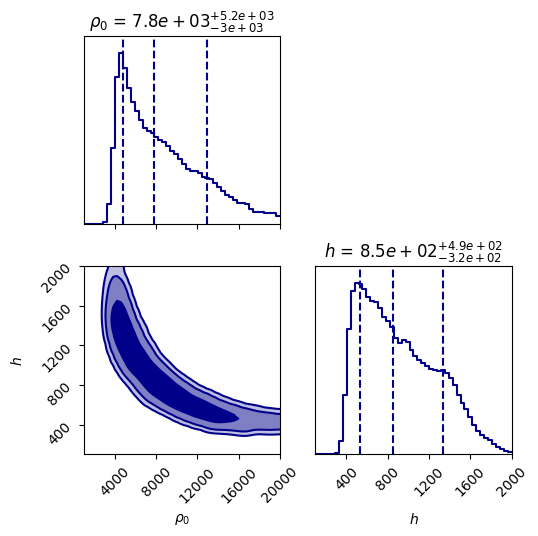

In [50]:
import corner

fig = corner.corner(
    flat_samples,
    labels=["$\\rho_0$", "$h$"],
    bins=50,
    color="darkblue",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,
    smooth=1.5, smooth1d=1.0,
    title_fmt=".2g",
    show_titles=True,
    range=[(1e3, 2e4), (100, 2000)]  # Manual axis limits
)
plt.tight_layout()
plt.show()

In [46]:
# For checking
print(flat_samples.shape)
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
# for _ in range(10):
#     scale = np.array([0.015, 0.006, 0.075, 0.04, 0.1, 0.1])
#     test = init_guess + np.random.normal(0, scale)
#     print(test, ln_post_nfw(test, xl, yl, el))

print(" Milky Way: NFW")

rho_samp= flat_samples[:, 0]  # rho_0
h_samp= flat_samples[:, 1]
# ---- SUMMARIZE RESULTS ----

print(f"rho_0 = {np.mean(rho_samp):.3f} ± {np.std(rho_samp):.3f}")
print(f"h = {np.mean(h_samp):.3f} ± {np.std(h_samp):.3f}")
tau = sampler.get_autocorr_time()
print(tau)
plt.plot(rho_samp)


(20000, 2)
Mean acceptance fraction: 0.5583
 Milky Way: NFW
rho_0 = 8671.700 ± 3841.603
h = 915.901 ± 361.948


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [52.29048832 52.87862665]

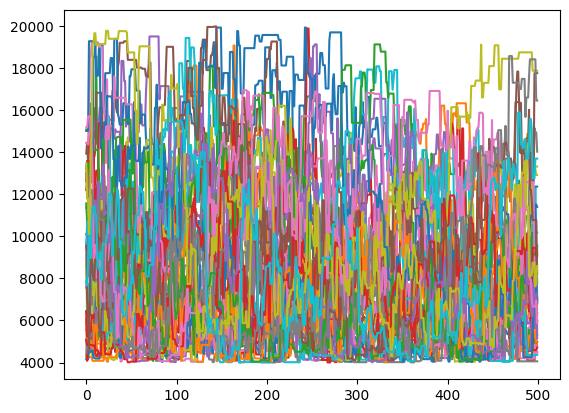

In [47]:
for i in range(0,nwalkers):
  a=sampler.chain[i,burnin:,0]
  l=len(a)
  n= list(range(l))
  plt.plot(n,a)
plt.show()

## FULL PARAM

In [128]:
def ln_likeli_nfw6(xl ,yl,el ,a_b, sig_b, a_d, sig_d, rho, h):
    vbulge = np.array([vb_numba(x, a_b, sig_b) for x in xl])
    vdisk  = np.array([vd_generic(x, a_d, sig_d) for x in xl])
    vhalo  = np.array([vh_nfw_vec(x, rho, h) for x in xl])
    vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)
    chi2 = np.sum((yl - vth)**2 / el**2)
    return -0.5 * chi2

def ln_prior_nfw6(theta ):
      a_b, sig_b, a_d, sig_d, rho, h= theta
      if not (1.6 < a_b < 1.9):
          return -np.inf
      if not (0.54e9 < sig_b < 0.63e9):
          return -np.inf
      if not ( 8 < a_d < 9.5 ):
          return -np.inf
      if not (0.52e9 < sig_d < 0.60e9):
          return -np.inf
      if not (4e3 < rho < 20e3):
          return -np.inf
      if not ( 250< h < 2000):
         return -np.inf
      return 0.0
    
def ln_post_nfw6(theta, xl, yl, el):
    a_b, sig_b, a_d, sig_d, rho, h= theta
    lp = ln_prior_nfw6(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likeli_nfw6(xl, yl, el, a_b, sig_b, a_d, sig_d, rho, h)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [129]:
init_guess = [1.764, 0.595e9 , 8.817, 0.566e9, 7120, 889]
for _ in range(20):
    theta = init_guess + np.random.normal(0, [ 0.015, 0.0045e9, 0.075, 0.004e9, 800, 87.5])
    t0 = time.time()
    val = ln_post_nfw6(theta, xl, yl, el)
    print(f"ln_post_nfw = {val:.9f}, Time = {time.time() - t0:.4f} sec")

/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v


ln_post_nfw = -521.198664184, Time = 0.5084 sec
ln_post_nfw = -514.483236607, Time = 0.4619 sec
ln_post_nfw = -524.150584208, Time = 0.4733 sec
ln_post_nfw = -518.005005617, Time = 0.4850 sec
ln_post_nfw = -509.966163865, Time = 0.4576 sec
ln_post_nfw = -512.606041502, Time = 0.4967 sec
ln_post_nfw = -515.207452357, Time = 0.4640 sec
ln_post_nfw = -515.080317433, Time = 0.5051 sec
ln_post_nfw = -513.651295850, Time = 0.4392 sec
ln_post_nfw = -514.383544357, Time = 0.4547 sec
ln_post_nfw = -509.377920386, Time = 0.5015 sec
ln_post_nfw = -508.006473988, Time = -0.9786 sec
ln_post_nfw = -510.648334225, Time = 0.5007 sec
ln_post_nfw = -512.419224142, Time = 0.4923 sec
ln_post_nfw = -508.266016108, Time = 0.4845 sec
ln_post_nfw = -508.147133772, Time = 0.4755 sec
ln_post_nfw = -509.033027550, Time = 0.3714 sec
ln_post_nfw = -510.393182375, Time = 0.3400 sec
ln_post_nfw = -508.933845655, Time = 0.3266 sec
ln_post_nfw = -513.555541245, Time = 0.3843 sec


In [138]:
# ---- MCMC SETUP ----
ndim = 6           # No. of parameters
nwalkers = 50      # Number of independent chains ("walkers")
nsteps = 12000      # Steps each walker takes
burnin = 3600      # Discard these initial steps (they're still "warming up")

# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(42)
init_guess = [1.764, 0.595e9 , 8.817, 0.566e9, 7120, 889]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0, [ 0.015, 0.0045e9, 0.075, 0.004e9, 800, 87.5], (nwalkers, ndim))

In [140]:
import multiprocessing
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler_n = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post_nfw6,
            args=(xl, yl, el),
            pool=pool
        )
        sampler_n.run_mcmc(pos, nsteps, progress=True)

    flat_samples_n = sampler_n.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples_n.shape)
'''
a flattened 2D version:
(nsteps × nwalkers - burnin × nwalkers, ndim)
All post-burn-in samples from all walkers are flattened into one big 2D array
Each row = one accepted parameter set (theta)
Shape = (N_samples, 6) 
'''


/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:15: DeprecationWarning: Conversion of an array with ndim 

Shape of samples: (420000, 6)


'\na flattened 2D version:\n(nsteps × nwalkers - burnin × nwalkers, ndim)\nAll post-burn-in samples from all walkers are flattened into one big 2D array\nEach row = one accepted parameter set (theta)\nShape = (N_samples, 6) \n'

In [141]:
print("Mean acceptance fraction:", np.mean(sampler_n.acceptance_fraction))          # _n denotes nfw
tau = sampler_n.get_autocorr_time()
print(tau)

Mean acceptance fraction: 0.3804383333333333
[115.82275385 115.39191409 111.28853321 125.02478822 225.34917366
 220.38667578]


In [142]:
print(" Milky Way: NFW")
ab_samp_n = flat_samples_n[:, 0]  # All sampled values of a_b
sb_samp_n = flat_samples_n[:, 1]  # All sampled values of sigma_b
ad_samp_n = flat_samples_n[:, 2]  # All sampled values of a_d
sd_samp_n = flat_samples_n[:, 3]  # All sampled values of sigma_d
rho_samp_n= flat_samples_n[:, 4]  # rho_0
h_samp_n = flat_samples_n[:, 5]    # h
# ---- SUMMARIZE RESULTS ----
print(f"a_b = {np.mean(ab_samp_n):.3f} ± {np.std(ab_samp_n):.3f}")                # EDIT THE NAME ab_samp ONCE GRAPH IS OBTAINED, EDIT FOR HERNQUIST AS WELL
print(f"sigma_b = {np.mean(sb_samp_n):.3f} ± {np.std(sb_samp_n):.3f}")
print(f"a_d = {np.mean(ad_samp_n):.3f} ± {np.std(ad_samp_n):.3f}")
print(f"sigma_d = {np.mean(sd_samp_n):.3f} ± {np.std(sd_samp_n):.3f}")
print(f"rho_0 = {np.mean(rho_samp_n):.3f} ± {np.std(rho_samp_n):.3f}")
print(f"h = {np.mean(h_samp_n):.3f} ± {np.std(h_samp_n):.3f}")

 Milky Way: NFW
a_b = 1.749 ± 0.037
sigma_b = 609651667.829 ± 13597248.488
a_d = 8.791 ± 0.302
sigma_d = 564225623.170 ± 15056528.657
rho_0 = 9534.717 ± 4430.448
h = 840.082 ± 365.664


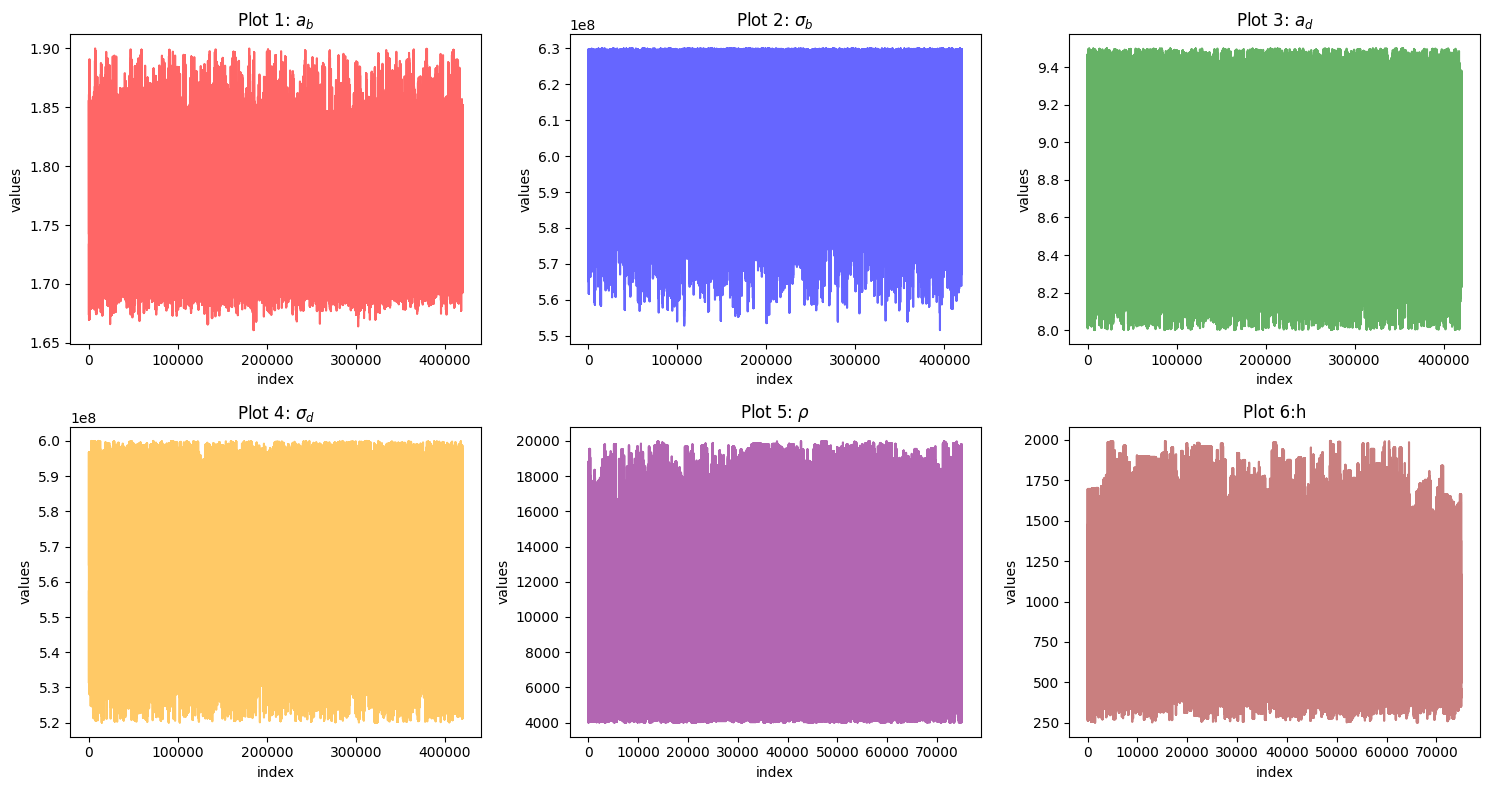

In [143]:
# Setup: 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Flatten for easier indexing
axes = axes.flatten()

# Plot 1
axes[0].plot(ab_samp_n, alpha=0.6, color='red')
axes[0].set_title("Plot 1: $a_b$")

# Plot 2
axes[1].plot(sb_samp_n, alpha=0.6, color='blue')
axes[1].set_title("Plot 2: $\\sigma_b$")

# Plot 3
axes[2].plot(ad_samp_n, alpha=0.6, color='green')
axes[2].set_title("Plot 3: $a_d$")

# Plot 4
axes[3].plot(sd_samp_n, alpha=0.6, color='orange')
axes[3].set_title("Plot 4: $\\sigma_d$")

# Plot 5
axes[4].plot(rho_samp, alpha=0.6, color='purple')
axes[4].set_title("Plot 5: $\\rho$")

# Plot 6
axes[5].plot(h_samp, alpha=0.6, color='brown')
axes[5].set_title("Plot 6:h")

# Labels, if needed
for ax in axes:
    ax.set_xlabel("index")
    ax.set_ylabel("values")

plt.tight_layout()
plt.show()


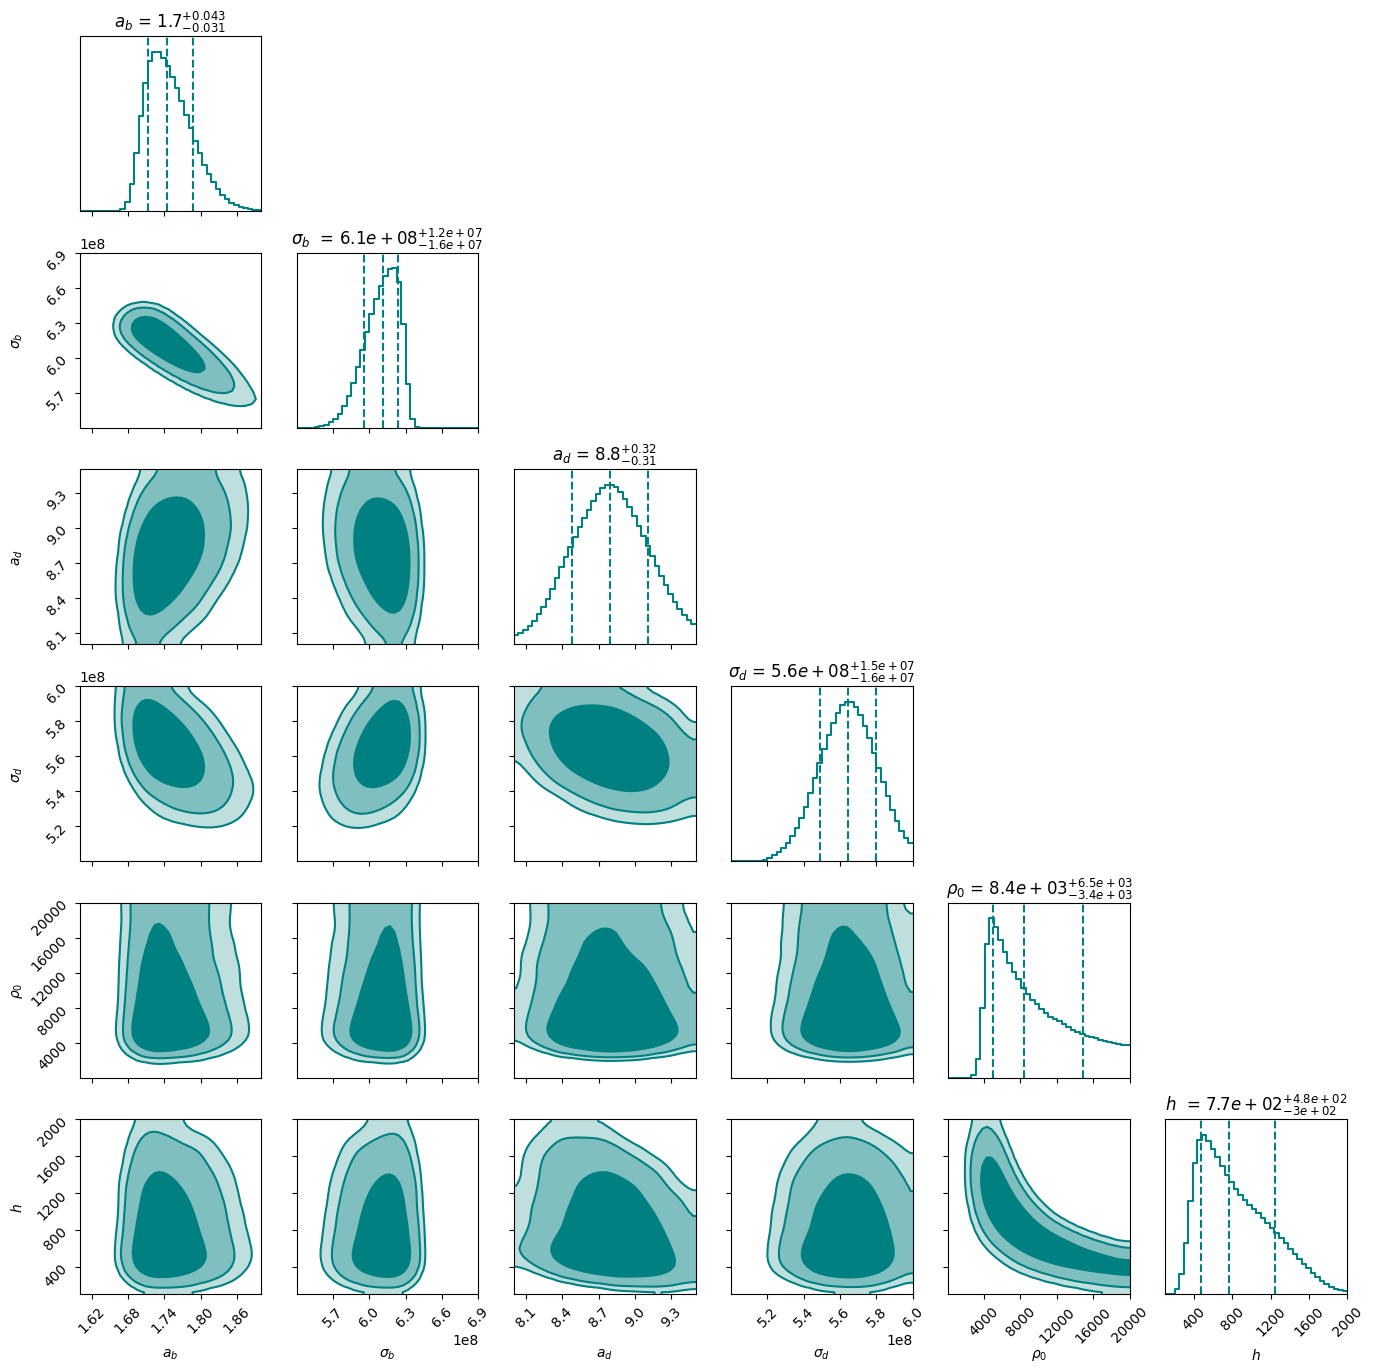

In [144]:
import corner

corner.corner(
    flat_samples_n,                                                                             
    labels=["$a_b$", "$\\sigma_b$ ", "$a_d$", "$\\sigma_d$", "$\\rho_0$", "$h$ "],
    bins=40,
    color="teal",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=2.0, smooth1d=1.0,
    title_fmt=".2g",
    show_titles=True,
    range= [(1.6, 1.9), (0.54e9, 0.69e9), (8.0, 9.5), (0.50e9, 0.60e9), (100, 2e4), (100, 2000)]
)
plt.tight_layout()
plt.show()

# EINASTO
## Hard Coded

In [65]:
def ln_likeli_ein(xl ,yl,el , rho, h, n):
    vbulge = np.array([vb_ein(x ) for x in xl])
    vdisk  = np.array([vd_ein_vec(x ) for x in xl])
    vhalo  = np.array([vh_ein_vec(x, rho, h, n) for x in xl])

    vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)
    chi2 = np.sum((yl - vth)**2 / el**2)
    return -0.5 * chi2

def ln_prior_ein(theta):
      rho, h, n = theta
    #   if not (1.7 < a_b <1.9):
    #       return -np.inf
    #   if not (0.56e9 < sig_b < 0.64e9):
    #       return -np.inf
    #   if not ( 8.5 < a_d < 10 ):
    #       return -np.inf
    #   if not (0.52e9 < sig_d < 0.62e9):
    #       return -np.inf
      if not (10e4< rho <50e4):
          return -np.inf
      if not ( 0< h< 20):
         return -np.inf
      if not ( -0.5<n< 0.5):
          return -np.inf
      return 0.0

def ln_post_ein(theta, xl, yl, el):
    rho, h, n = theta
    lp = ln_prior_ein(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likeli_ein(xl, yl, el, rho, h, n)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [ ]:
#init_guess = [1.775, 0.593e9, 9.13, 0.578e9, 24.866e4, 8.745, 0.041]  ,   np.random.normal(0, [0.01, 0.004e9, 0.075, 0.005e9, 2e4, 1, 0.05 ], (nwalkers, ndim))
init_guess = [ 24.866e4, 8.745, 0.041]
for _ in range(10):
    theta = init_guess + np.random.normal(0, [2e4, 1, 0.05]) 
    t0 = time.time()
    val = ln_post_ein(theta, xl, yl, el)
    print(f"ln_post_ein = {val:.9f}, Time = {time.time() - t0:.4f} sec")

/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v


ln_post_ein = -533.532787448, Time = 0.2913 sec
ln_post_ein = -534.630898765, Time = 0.3705 sec
ln_post_ein = -533.527582345, Time = 0.3512 sec
ln_post_ein = -533.627638259, Time = 0.3531 sec
ln_post_ein = -533.551433587, Time = 0.3435 sec
ln_post_ein = -533.566204215, Time = 0.2866 sec
ln_post_ein = -533.514805306, Time = 0.2893 sec
ln_post_ein = -533.516847583, Time = 0.3857 sec
ln_post_ein = -533.379754881, Time = 0.3688 sec
ln_post_ein = -534.197159690, Time = 0.2246 sec


/tmp/ipykernel_8220/1045807049.py:33: RuntimeWarning: overflow encountered in power
  x = (r[ r > 0] / h)**(1/n)


In [90]:
# ---- MCMC SETUP ----
ndim = 3          # No. of parameters
nwalkers = 50      # Number of independent chains ("walkers")
nsteps = 7000      # Steps each walker takes
burnin = 150      # Discard these initial steps (they're still "warming up")

# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(42)
init_guess = [24.866e4, 8.745, 0.041 ]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0, [ 2e4, 1, 0.05 ], (nwalkers, ndim))

if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post_ein,
            args=(xl, yl, el),
            pool=pool
        )
        sampler.run_mcmc(pos, nsteps, progress=True)

    flat_samples = sampler.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples.shape)

/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim 

Shape of samples: (342500, 3)


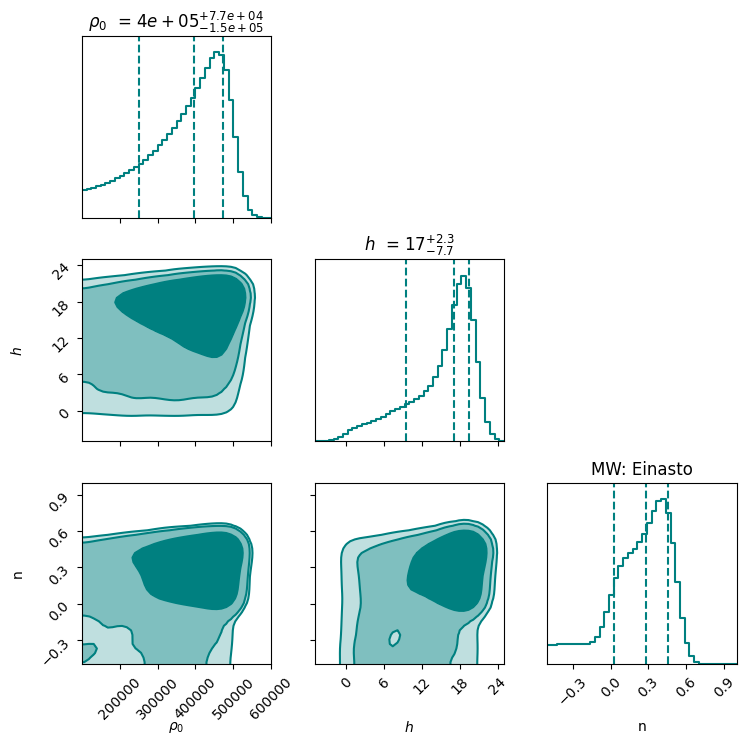

In [100]:
corner.corner(
    flat_samples,                                                                           
    labels=["$\\rho_0$ ", "$h$ ", "n"],
    bins=40,
    color="teal",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=2, smooth1d=2.0,
    title_fmt=".2g",
    show_titles=True,
    range=[(10e4, 60e4), (-5, 25), (-0.5, 1.0)]
)
plt.tight_layout()
plt.title('MW: Einasto')
plt.show()

In [92]:
print(" Milky Way: Einasto")
rho_samp= flat_samples[:, 0]  # All sampled values of rho_0
h_samp= flat_samples[:, 1]    # All sampled values of h
n_samp= flat_samples[:, 2]    # All sampled values of n
# ---- SUMMARIZE RESULTS ----

print(f"rho_0 = {np.mean(rho_samp):.3f} ± {np.std(rho_samp):.3f}")
print(f"h = {np.mean(h_samp):.3f} ± {np.std(h_samp):.3f}")
print(f"n = {np.mean(n_samp):.3f} ± {np.std(n_samp):.3f}")

 Milky Way: Einasto
rho_0 = 369468.318 ± 103695.487
h = 15.064 ± 5.030
n = 0.227 ± 0.231


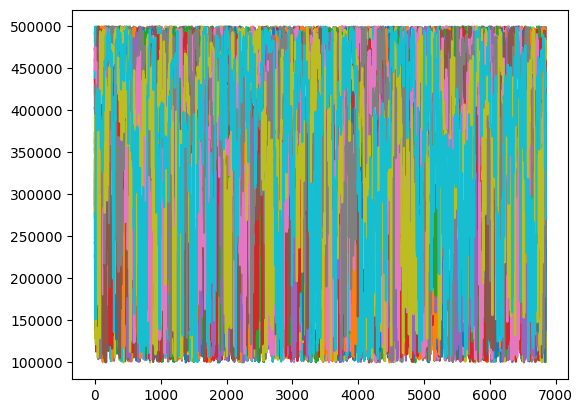

Mean acceptance fraction =>  0.4548914285714286


In [93]:
for i in range(0, nwalkers):
  a=sampler.chain[i,burnin:,0]
  l=len(a)
  n= list(range(l))
  plt.plot(n,a)
plt.show()
print( "Mean acceptance fraction => ", np.mean(sampler.acceptance_fraction))


[77.51148818 91.21340192 82.79309063]


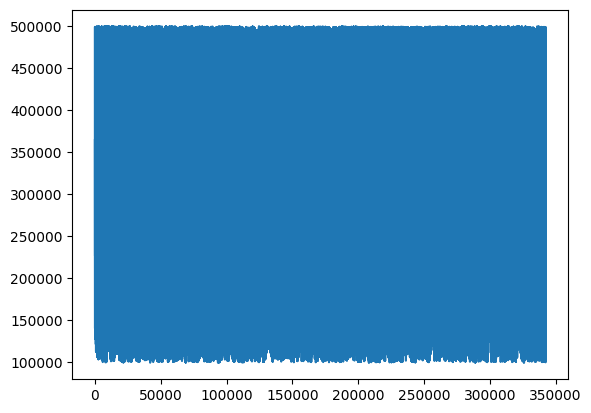

In [94]:
tau = sampler.get_autocorr_time()
# effective_samples = nsteps / tau (τ tells you: how many steps it takes for the chain to “forget” its past)
print(tau)
plt.plot(rho_samp)


## FULL PARAMETERS

In [ ]:
def ln_likeli_ein7(xl ,yl,el ,a_b, sig_b, a_d, sig_d, rho, h, n):
    vbulge = np.array([vb_numba(x, a_b, sig_b ) for x in xl])
    vdisk  = np.array([vd_generic(x, a_d, sig_d ) for x in xl])
    vhalo  = np.array([vh_ein_vec(x, rho, h, n) for x in xl])
    vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)
    chi2 = np.sum((yl - vth)**2 / el**2)
    return -0.5 * chi2

def ln_prior_ein7(theta):
      a_b, sig_b, a_d, sig_d, rho, h, n = theta
      if not (1.7 < a_b <1.9):
          return -np.inf
      if not (0.56e9 < sig_b < 0.64e9):
          return -np.inf
      if not ( 8 < a_d < 10 ):
          return -np.inf
      if not (0.52e9 < sig_d < 0.62e9):
          return -np.inf
      if not (5e4< rho <50e4):
          return -np.inf
      if not ( -5< h< 30):
         return -np.inf
      if not ( -0.5<n< 0.5):
          return -np.inf
      return 0.0

def ln_post_ein7(theta, xl, yl, el):
    a_b, sig_b, a_d, sig_d, rho, h, n = theta
    lp = ln_prior_ein7(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likeli_ein7(xl, yl, el,a_b, sig_b, a_d, sig_d, rho, h, n)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [157]:
init_guess = [1.775, 0.593e9 , 9.130, 0.578e9, 248660, 8.745, 0.041]
for _ in range(20):
    theta = init_guess + np.random.normal(0, [ 0.01, 0.004e9, 0.1, 0.005e9, 2.25e4, 1.75, 0.05])
    t0 = time.time()
    val = ln_post_ein7(theta, xl, yl, el)
    print(f"ln_post_ein = {val:.9f}, Time = {time.time() - t0:.4f} sec")

/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v


ln_post_ein = -527.861034099, Time = 0.3572 sec
ln_post_ein = -534.724104660, Time = 0.3183 sec
ln_post_ein = -532.151276568, Time = 0.4038 sec
ln_post_ein = -526.053609008, Time = 0.3015 sec


/tmp/ipykernel_8220/1045807049.py:33: RuntimeWarning: overflow encountered in power
  x = (r[ r > 0] / h)**(1/n)


ln_post_ein = -534.108327646, Time = 0.2727 sec
ln_post_ein = -526.709211750, Time = 0.4190 sec
ln_post_ein = -529.938296252, Time = 0.3115 sec
ln_post_ein = -536.715499655, Time = 0.3347 sec
ln_post_ein = -538.357093338, Time = 0.3598 sec
ln_post_ein = -530.944008345, Time = 0.3905 sec
ln_post_ein = -532.175038168, Time = 0.3308 sec
ln_post_ein = -537.383081309, Time = 0.3431 sec
ln_post_ein = -527.855704479, Time = 0.3941 sec
ln_post_ein = -548.291964253, Time = 0.3303 sec
ln_post_ein = -538.897220064, Time = 0.2859 sec
ln_post_ein = -540.937841310, Time = 0.2681 sec
ln_post_ein = -535.865621481, Time = 0.3301 sec
ln_post_ein = -546.668440653, Time = 0.3228 sec
ln_post_ein = -524.361045370, Time = 0.3123 sec
ln_post_ein = -540.926967787, Time = 0.3980 sec


In [159]:
# ---- MCMC SETUP ----
ndim = 7          # No. of parameters
nwalkers = 50      # Number of independent chains ("walkers")
nsteps = 10000      # Steps each walker takes
burnin = 2000      # Discard these initial steps (they're still "warming up")

# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(42)
init_guess = [1.775, 0.593e9 , 9.130, 0.578e9, 248660, 8.745, 0.041]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0, [0.01, 0.004e9, 0.1, 0.005e9, 2e4, 1.75, 0.05 ], (nwalkers, ndim))

if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler_e = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post_ein7,
            args=(xl, yl, el),
            pool=pool
        )
        sampler_e.run_mcmc(pos, nsteps, progress=True)

    flat_samples_e = sampler_e.get_chain(discard=burnin, thin= 10, flat=True)      # thin, used to reduce autocorrelation by keeping every thin-th sample
    print("Shape of samples:", flat_samples_e.shape)

/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:38: DeprecationWarning: Conversion of an array with ndim 

Shape of samples: (40000, 7)


In [160]:
print("Mean acceptance fraction:", np.mean(sampler_e.acceptance_fraction))          # _n denotes nfw
tau = sampler_e.get_autocorr_time()
print(tau)

Mean acceptance fraction: 0.316084
[165.56999194 163.32382823 192.68529137 162.95350827 170.720184
 183.40504876 185.57012532]


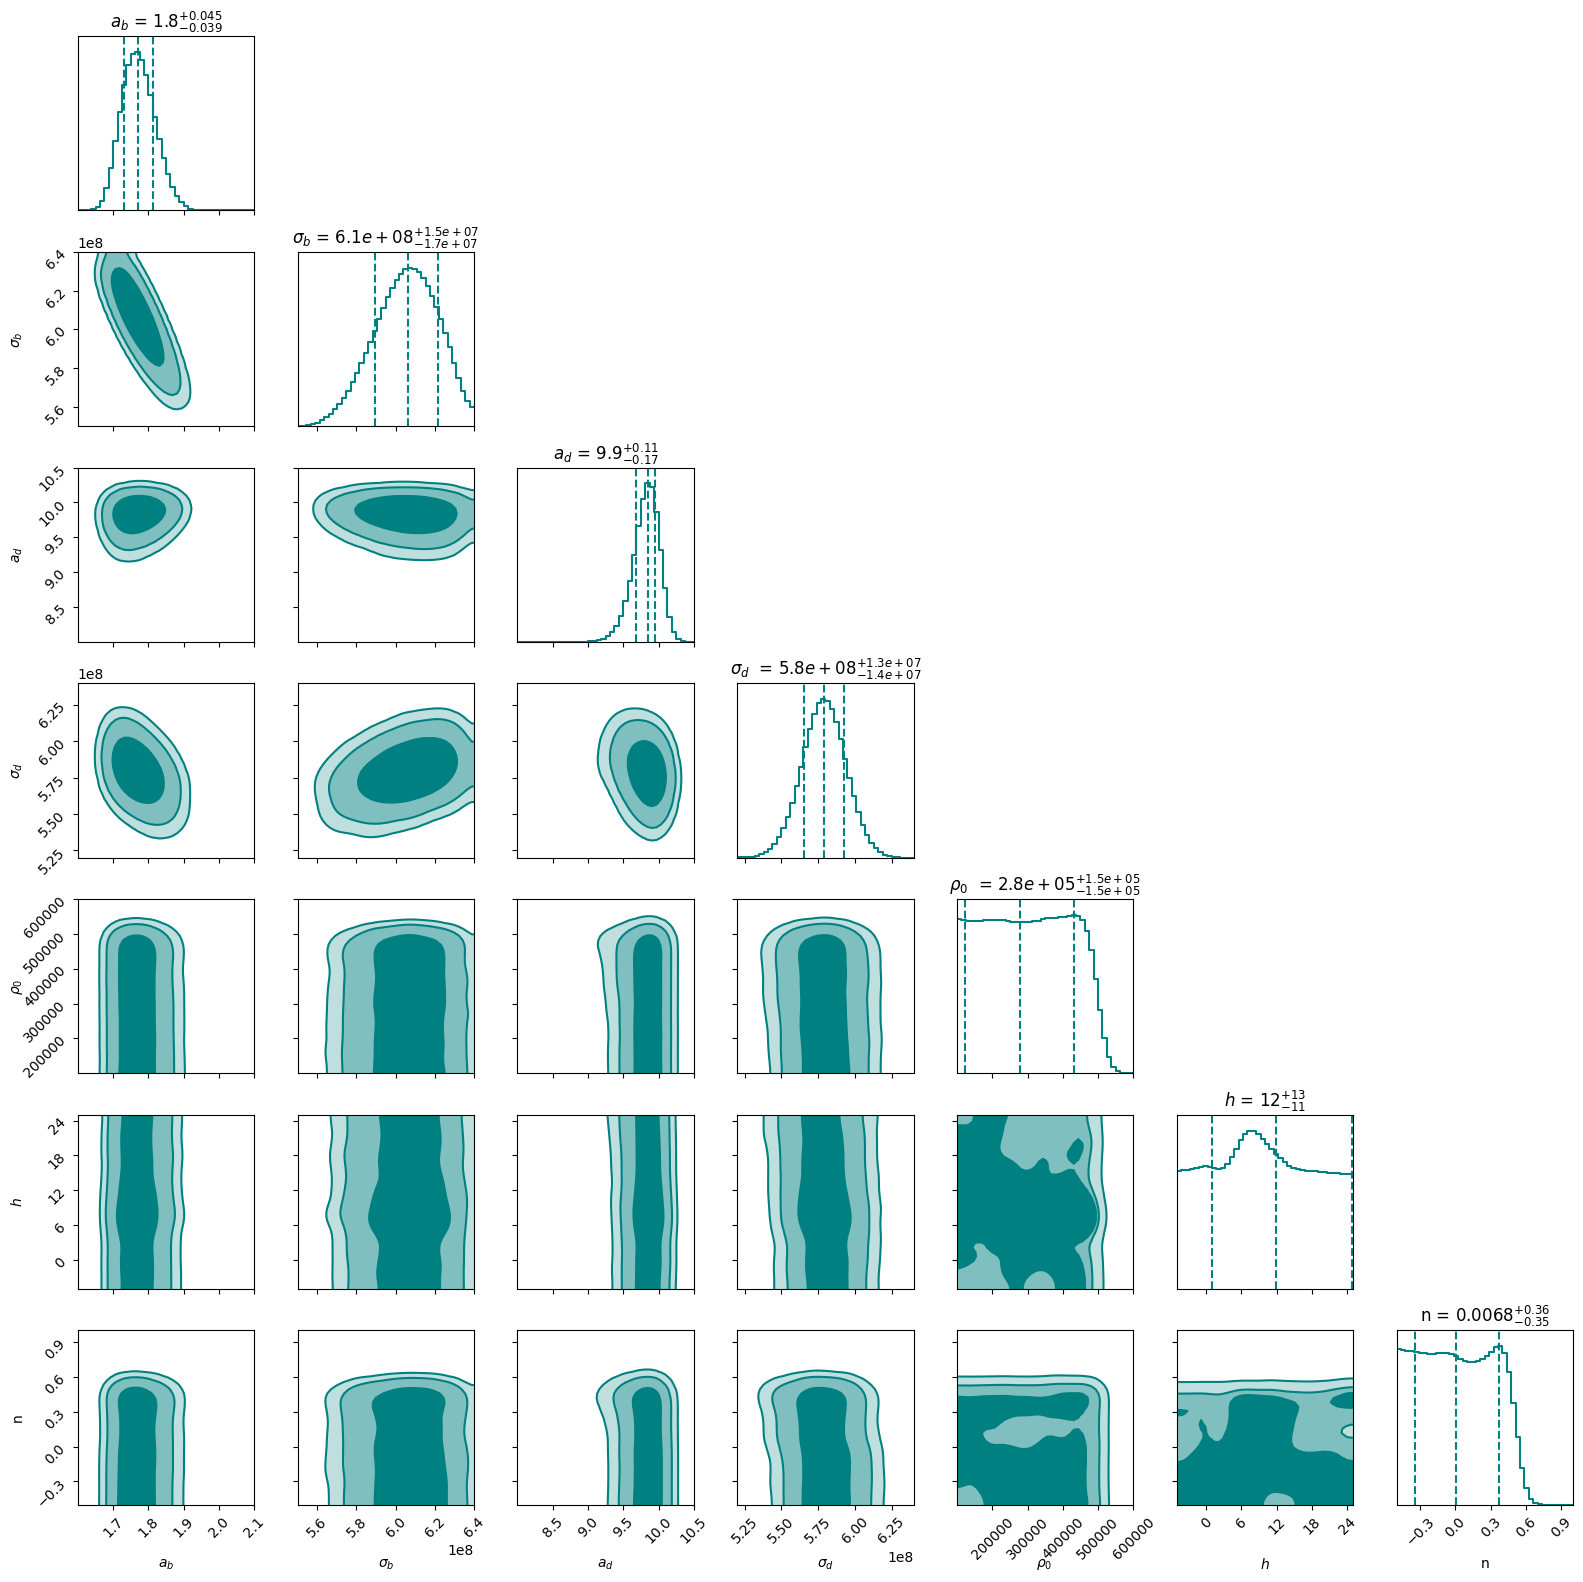

In [166]:
corner.corner(
    flat_samples_e,                                                                           
    labels=["$a_b$", "$\\sigma_b$", "$a_d$", "$\\sigma_d$ ", "$\\rho_0$ ", "$h$", "n"],
    bins=40,
    color="teal",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=2, smooth1d=2.0,
    title_fmt=".2g",
    show_titles=True,
    range=[(1.6,2.1), (0.55e9,0.64e9), (8,10.5), (0.52e9, 0.64e9), (10e4, 60e4), (-5, 25), (-0.5, 1.0)]
)
plt.tight_layout()
plt.show()

In [162]:
print(" Milky Way: Einasto")
ab_samp_e = flat_samples_e[:, 0]  # All sampled values of 
sb_samp_e = flat_samples_e[:, 1]  # All sampled values of 
ad_samp_e = flat_samples_e[:, 2]  # All sampled values of a_d
sd_samp_e = flat_samples_e[:, 3]  # All sampled values of sigma_d
rho_samp_e= flat_samples_e[:, 4]  # All sampled values of rho_0
h_samp_e= flat_samples_e[:, 5]    # All sampled values of h
n_samp_e= flat_samples_e[:, 6]    # All sampled values of n
# ---- SUMMARIZE RESULTS ----
print(f"a_b = {np.mean(ab_samp_e):.3f} ± {np.std(ab_samp_e):.3f}")
print(f"sigma_b = {np.mean(sb_samp_e):.3f} ± {np.std(sb_samp_e):.3f}")
print(f"a_d = {np.mean(ad_samp_e):.3f} ± {np.std(ad_samp_e):.3f}")
print(f"sigma_d = {np.mean(sd_samp_e):.3f} ± {np.std(sd_samp_e):.3f}")
print(f"rho_0 = {np.mean(rho_samp_e):.3f} ± {np.std(rho_samp_e):.3f}")
print(f"h = {np.mean(h_samp_e):.3f} ± {np.std(h_samp_e):.3f}")
print(f"h = {np.mean(n_samp_e):.3f} ± {np.std(n_samp_e):.3f}")

 Milky Way: Einasto
a_b = 1.772 ± 0.040
sigma_b = 605356480.847 ± 15302603.893
a_d = 9.821 ± 0.141
sigma_d = 578884012.836 ± 13630609.620
rho_0 = 277217.624 ± 130148.798
h = 12.532 ± 10.046
h = 0.011 ± 0.297


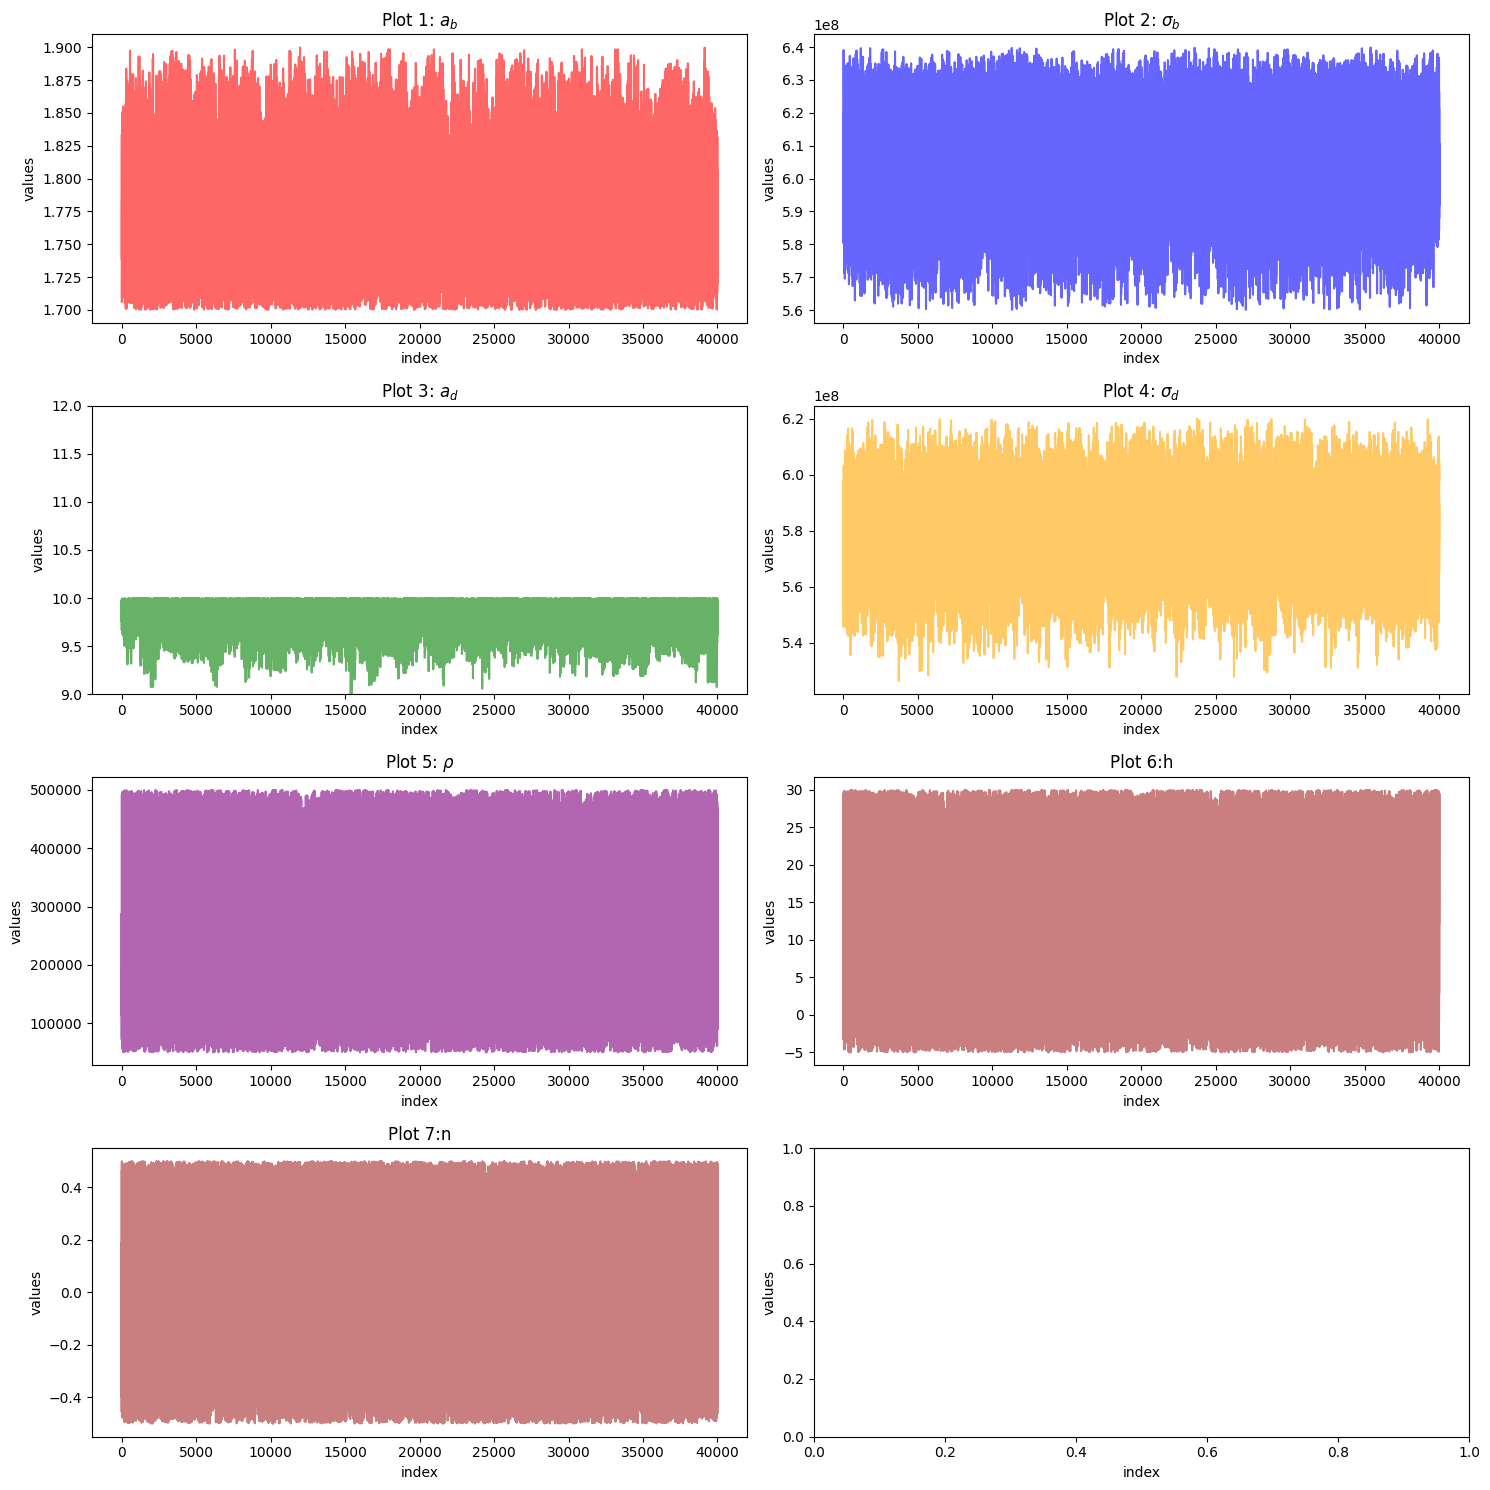

In [165]:
# Setup: 2 rows × 3 columns
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

# Flatten for easier indexing
axes = axes.flatten()

# Plot 1
axes[0].plot(ab_samp_e, alpha=0.6, color='red')
axes[0].set_title("Plot 1: $a_b$")

# Plot 2
axes[1].plot(sb_samp_e, alpha=0.6, color='blue')
axes[1].set_title("Plot 2: $\\sigma_b$")

# Plot 3
axes[2].plot(ad_samp_e, alpha=0.6, color='green')
axes[2].set_title("Plot 3: $a_d$")
axes[2].set_ylim(9,12)

# Plot 4
axes[3].plot(sd_samp_e, alpha=0.6, color='orange')
axes[3].set_title("Plot 4: $\\sigma_d$")

# Plot 5
axes[4].plot(rho_samp_e, alpha=0.6, color='purple')
axes[4].set_title("Plot 5: $\\rho$")

# Plot 6
axes[5].plot(h_samp_e, alpha=0.6, color='brown')
axes[5].set_title("Plot 6:h")

# Plot 7
axes[6].plot(n_samp_e, alpha=0.6, color='brown')
axes[6].set_title("Plot 7:n")

# Labels, if needed
for ax in axes:
    ax.set_xlabel("index")
    ax.set_ylabel("values")

plt.tight_layout()
plt.show()


# HERNQUIST
## Full Parameter

In [103]:
def ln_likeli_hern(xl ,yl,el ,a_b, sig_b, a_d, sig_d, rho, h):
    vbulge = np.array([vb_numba(x, a_b, sig_b,) for x in xl])
    vdisk  = np.array([vd_generic(x, a_d, sig_d) for x in xl])
    vhalo  = np.array([vh_hern_vec(x, rho, h) for x in xl])
    vth = np.sqrt(vbulge**2 +vdisk**2 + vhalo**2)
    chi2 = np.sum((yl - vth)**2 / el**2)
    return -0.5 * chi2

def ln_prior_hern(theta):                                        # Uniform prior
      a_b, sig_b, a_d, sig_d, rho, h = theta
      if not (1.6 < a_b < 1.9):
          return -np.inf
      if not (0.55e9 < sig_b < 0.625e9):
          return -np.inf
      if not ( 8.5 < a_d < 10 ):
          return -np.inf
      if not (0.52e9 < sig_d < 0.60e9):
          return -np.inf
      if not (4e4 < rho < 8e4):
          return -np.inf
      if not ( 130< h < 160):
         return -np.inf
      return 0.0
  
def ln_post_hern(theta, xl, yl, el):
    a_b, sig_b, a_d, sig_d, rho, h = theta
    lp = ln_prior_hern(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likeli_hern(xl, yl, el, a_b, sig_b, a_d, sig_d, rho, h)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [105]:
init_guess = [ 1.775, 0.592e9, 9.237, 0.552e9, 6.309e4, 142.324]
for _ in range(10):
    theta = init_guess + np.random.normal(0, [0.015, 0.004e9, 0.075, 0.004e9, 0.2e4, 1.5]) 
    t0 = time.time()
    val = ln_post_hern(theta, xl, yl, el)
    print(f"ln_post_hern = {val:.9f}, Time = {time.time() - t0:.4f} sec")

/tmp/ipykernel_8220/1045807049.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v


ln_post_hern = -512.592695593, Time = 0.4504 sec
ln_post_hern = -512.585123471, Time = 0.4648 sec
ln_post_hern = -518.784552713, Time = 0.4369 sec
ln_post_hern = -511.498890590, Time = 0.4625 sec
ln_post_hern = -513.896375282, Time = 0.4631 sec
ln_post_hern = -513.133967595, Time = 0.5023 sec
ln_post_hern = -517.803906707, Time = 0.4577 sec
ln_post_hern = -517.783194417, Time = 0.4827 sec
ln_post_hern = -528.251443758, Time = 0.5025 sec
ln_post_hern = -511.265279633, Time = 0.4942 sec


In [109]:
# ---- MCMC SETUP ----
ndim = 6           # No. of parameters
nwalkers = 50      # Number of independent chains ("walkers")
nsteps = 5000      # Steps each walker takes
burnin = 1000      # Discard these initial steps (they're still "warming up")

# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(42)
init_guess = [1.775, 0.592e9, 9.237, 0.552e9, 6.309e4, 142.324 ] # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0,[0.015, 0.004e9, 0.075, 0.004e9, 0.2e4, 1.5] , (nwalkers, ndim))

In [110]:
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler_h = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post_hern,
            args=(xl, yl, el),
            pool=pool
        )
        sampler_h.run_mcmc(pos, nsteps, progress=True)

    flat_samples_h = sampler_h.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples_h.shape)

/tmp/ipykernel_8220/1045807049.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v) if v.shape == (1,) else v
/tmp/ipykernel_8220/1045807049.py:26: DeprecationWarning: Conversion of an array with ndim 

Shape of samples: (200000, 6)


In [115]:
print(" Milky Way:Hernquist")
ab_samp = flat_samples_h[:, 0]  # All sampled values of a_b
sb_samp = flat_samples_h[:, 1]  # All sampled values of sigma_b
ad_samp = flat_samples_h[:, 2]  # All sampled values of a_d
sd_samp = flat_samples_h[:, 3]  # All sampled values of sigma_d
rho_samp= flat_samples_h[:, 4]  # rho_0
h_samp= flat_samples_h[:, 5]
# ---- SUMMARIZE RESULTS ----
print(f"a_b = {np.mean(ab_samp):.3f} ± {np.std(ab_samp):.3f}")
print(f"sigma_b = {np.mean(sb_samp):.3f} ± {np.std(sb_samp):.3f}")
print(f"a_d = {np.mean(ad_samp):.3f} ± {np.std(ad_samp):.3f}")
print(f"sigma_d = {np.mean(sd_samp):.3f} ± {np.std(sd_samp):.3f}")
print(f"rho_0 = {np.mean(rho_samp):.3f} ± {np.std(rho_samp):.3f}")
print(f"h = {np.mean(h_samp):.3f} ± {np.std(h_samp):.3f}")

 Milky Way:Hernquist
a_b = 1.760 ± 0.035
sigma_b = 606034563.982 ± 12670970.283
a_d = 9.092 ± 0.270
sigma_d = 551533261.048 ± 14701578.810
rho_0 = 66450.308 ± 9768.761
h = 148.541 ± 8.034


In [118]:
print(" Mean acceptance fraction => ", np.mean(sampler_h.acceptance_fraction))
tau = sampler_h.get_autocorr_time()
# effective_samples = nsteps / tau (τ tells you: how many steps it takes for the chain to “forget” its past)
print(tau)
plt.plot(rho_samp)


 Mean acceptance fraction =>  0.41341200000000006


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [ 94.37989257  92.20544278  95.5404796   84.7999215  105.14048547
 102.64885557]

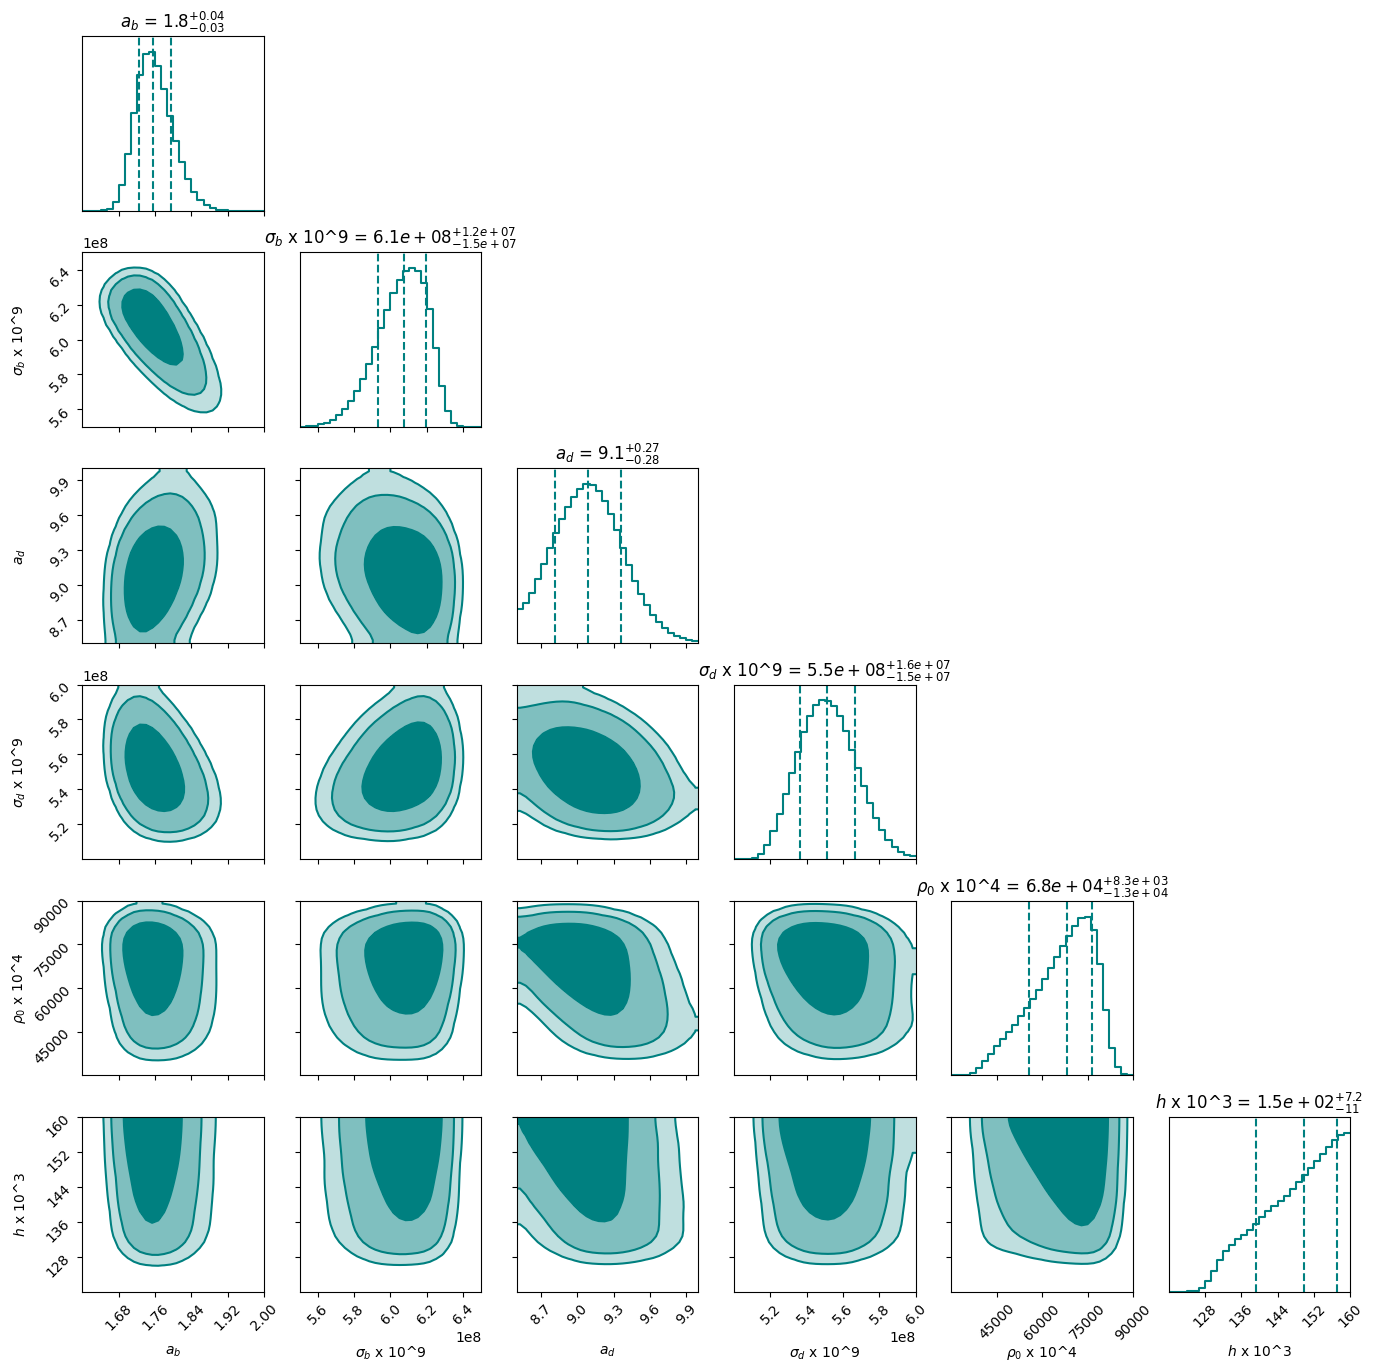

In [114]:
corner.corner(
    flat_samples_h,                                                                              # samples_scaled, in place of flat samples?
    labels=["$a_b$", "$\\sigma_b$ x 10^9", "$a_d$", "$\\sigma_d$ x 10^9", "$\\rho_0$ x 10^4", "$h$ x 10^3"],
    bins=30,
    color="teal",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=2.0, smooth1d=1.5,
    title_fmt=".2g",
    show_titles=True,
    range= [(1.6,2.0), (0.55e9, 0.65e9), (8.5, 10.0), (0.50e9, 0.60e9), (3e4,9e4), (120,160)]
)
plt.tight_layout()
plt.show()

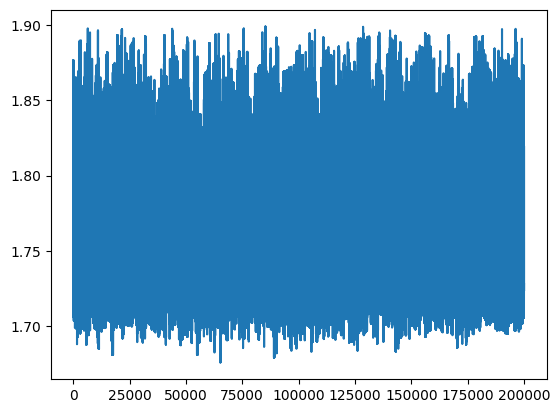

In [120]:
plt.plot(ab_samp)

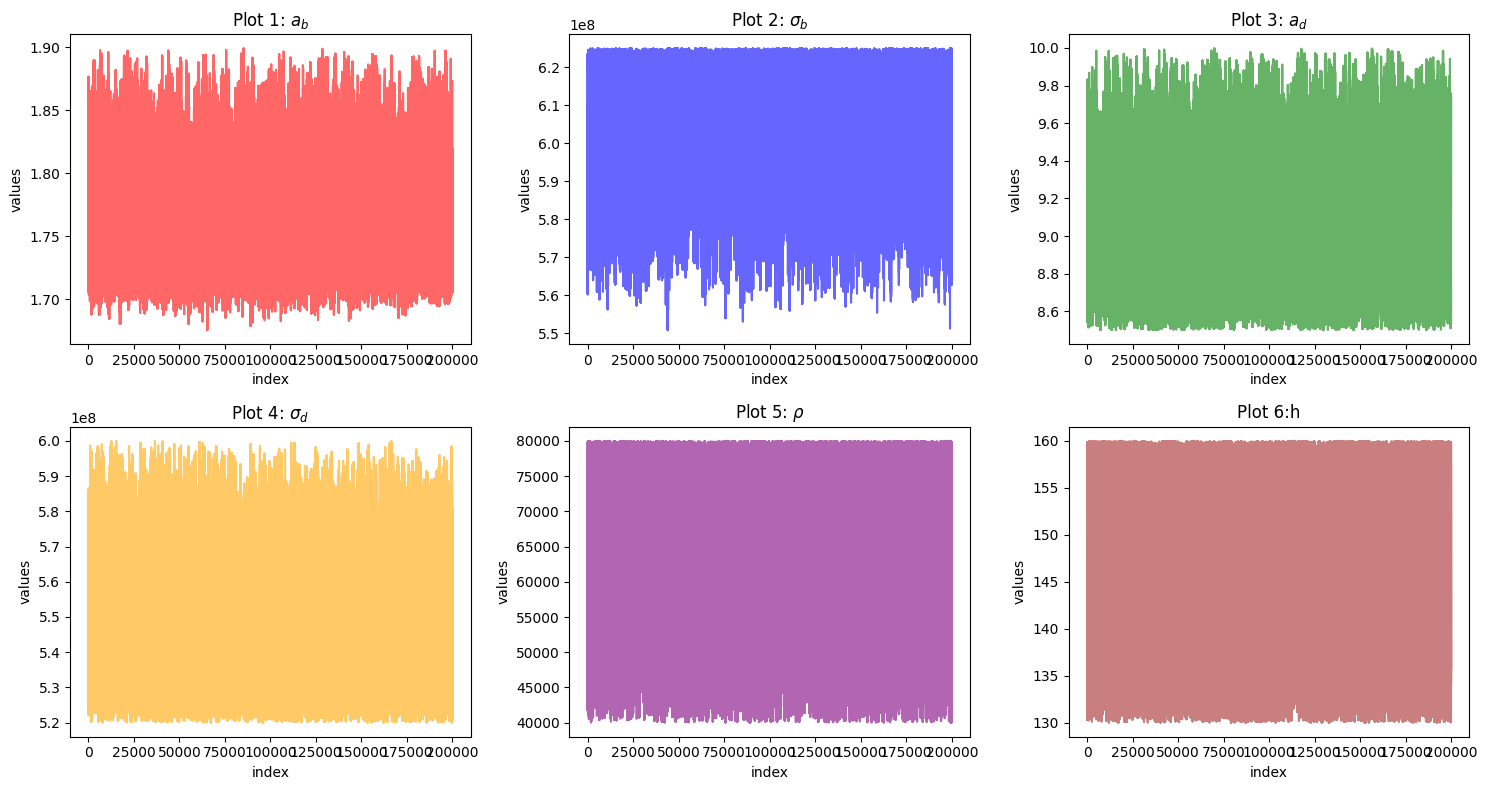

In [122]:
# Setup: 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Flatten for easier indexing
axes = axes.flatten()

# Plot 1
axes[0].plot(ab_samp, alpha=0.6, color='red')
axes[0].set_title("Plot 1: $a_b$")

# Plot 2
axes[1].plot(sb_samp, alpha=0.6, color='blue')
axes[1].set_title("Plot 2: $\\sigma_b$")

# Plot 3
axes[2].plot(ad_samp, alpha=0.6, color='green')
axes[2].set_title("Plot 3: $a_d$")

# Plot 4
axes[3].plot(sd_samp, alpha=0.6, color='orange')
axes[3].set_title("Plot 4: $\\sigma_d$")

# Plot 5
axes[4].plot(rho_samp, alpha=0.6, color='purple')
axes[4].set_title("Plot 5: $\\rho$")

# Plot 6
axes[5].plot(h_samp, alpha=0.6, color='brown')
axes[5].set_title("Plot 6:h")

# Labels, if needed
for ax in axes:
    ax.set_xlabel("index")
    ax.set_ylabel("values")

plt.tight_layout()
plt.show()
